In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

# Convolutional Neural Networks in Action <a class='tocSkip'>

*Machine Learning 3*

*Prepared by Leodegario Lorenzo II*

References:

1. Deep Learning with PyTorch, Eli Stevents, Luca Antga, Thomas Viehmann (2022, Manning Publications)
2. Deep Learning with Python, Francois Chollet, (2018, Manning Publications)
3. Deep Learning for Coders with fastai and PyTorch, Jeremy Howard, Sylvain Gugger (2022, O'Reilly Media)

## 0 PyTorch for deep learning <a class='tocSkip'>

**What is PyTorch?**

PyTorch is a library for Python programs that facilitates building deep learning projects. It emphasizes flexibiity and allows deep learning models to be expressed in idiomatic Python.

**Why PyTorch?**

PyTorch is a suitable framework for deep learning projects for various reasons:

1. It is simple. Users find it easy to learn, use, extend, and debug. It is not a framework allowing developers to be more expressive enabling them to implement complicated models without undue complexity.
2. Deep learning is very natural in PyTorch. Its syntax is Pythonic, it feels very familiar to developers who have used Python previously.  It also provides facilities that support numerical optimizations on generic mathematical expressions which deep learning uses for training.
3. Provides accelerated computation using GPUs and can be employed to use multiple machines during training. PyTorch was initially focused on research wor.kflows. Used C++ runtime that can be used to deploy models for inference without relying on Python.

**What is the usual structure of a PyTorch project?**

<img src='./images/pytorch-project.png' width=650/>

First, we need to physically get the dat most often from some storage. Then convert each sample to something that PyTorch can read: *tensors*. The training loop is usually implemented as a standard Python `for` loop. Afterwards, the model can be deployed on a server or export into a cloud engine or integrated in an application.

## CIFAR-10 Dataset

The dataset that we will use in our discussion is the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). It is a dataset that consists of tiny 32 x 32 RGB images labeled with an integer corresponding to 1 of 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

We will use `torchvision` to download these datasets directly onto our local machines.

In [3]:
from torchvision import datasets

In [4]:
data_path = './data/cifar-10/'
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


We can inspect the datasets by directly indexing the `Dataset` object

In [5]:
import matplotlib.pyplot as plt

In [6]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

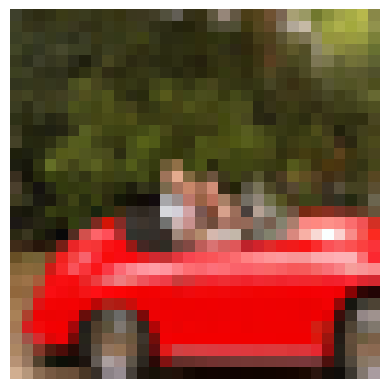

In [7]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off');

## Data Preprocessing

### Normalizing the data

In [8]:
from torchvision import transforms

In [9]:
tensor_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False, transform=transforms.ToTensor())

In [10]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)

In [11]:
means = imgs.view(3, -1).mean(dim=1).numpy()

In [12]:
stds = imgs.view(3, -1).std(dim=1).numpy()

In [13]:
means, stds

(array([0.49139965, 0.48215845, 0.44653094], dtype=float32),
 array([0.24703224, 0.24348514, 0.26158786], dtype=float32))

In [14]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

In [15]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transformations
)

In [16]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transformations
)

### Is it a bird? Is it a plane?

In [17]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

### Data loader

In [18]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

## Model Building

<img src='./images/baseline-architecture.png' width=250/>

In [19]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

In [20]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

## Model Training

In [21]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [22]:
from torch import optim

In [23]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(100, optimizer, model, loss_fn, train_loader=train_loader)

2023-04-14 06:38:22.238977 Epoch 1, Training loss 0.579411323093305
2023-04-14 06:38:28.994966 Epoch 10, Training loss 0.33024542536705165
2023-04-14 06:38:35.793643 Epoch 20, Training loss 0.2915535759963807
2023-04-14 06:38:42.423494 Epoch 30, Training loss 0.267597727809742
2023-04-14 06:38:49.225015 Epoch 40, Training loss 0.24678098011738175
2023-04-14 06:38:56.075038 Epoch 50, Training loss 0.2282219613623467
2023-04-14 06:39:03.507108 Epoch 60, Training loss 0.2150772983670994
2023-04-14 06:39:11.439463 Epoch 70, Training loss 0.19786105509016924
2023-04-14 06:39:19.038775 Epoch 80, Training loss 0.18659346142582073
2023-04-14 06:39:26.612989 Epoch 90, Training loss 0.16813478932069365
2023-04-14 06:39:33.453152 Epoch 100, Training loss 0.15554255519987673


## Model Validation

In [24]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [25]:
validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.86


## Model Saving and Loading

In [26]:
torch.save(model.state_dict(), './bird_or_plane.pt')

In [27]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('./bird_or_plane.pt'))

<All keys matched successfully>

## Training on GPU

In [28]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [24]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [27]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(100, optimizer, model, loss_fn, train_loader=train_loader)

2023-04-14 07:22:23.549917 Epoch 1, Training loss 0.5618082770876064
2023-04-14 07:22:29.373536 Epoch 10, Training loss 0.3326062721431635
2023-04-14 07:22:35.613281 Epoch 20, Training loss 0.29601489263735
2023-04-14 07:22:42.293188 Epoch 30, Training loss 0.26567471093812567
2023-04-14 07:22:47.487144 Epoch 40, Training loss 0.24442960160553076
2023-04-14 07:22:54.177078 Epoch 50, Training loss 0.2269245014543746
2023-04-14 07:23:00.747240 Epoch 60, Training loss 0.212961825500628
2023-04-14 07:23:07.613348 Epoch 70, Training loss 0.19840166399813003
2023-04-14 07:23:14.386494 Epoch 80, Training loss 0.18440728349860308
2023-04-14 07:23:21.257854 Epoch 90, Training loss 0.17215606857352195
2023-04-14 07:23:28.067509 Epoch 100, Training loss 0.15774712830212465
